# Machine Learning Project

## Background

Automatic fake news detection is a challenging problem in deception detection, and it has tremendous real-world political and social impacts. However, statistical approaches to combating fake news has been dramatically limited by the lack of labeled benchmark datasets. Here, we use LIAR: a new, publicly available dataset for fake news detection. It is a collection a decade-long, 12.8K manually labeled short statements in various contexts from POLITIFACT.COM, which provides detailed analysis report and links to source documents for each case. We will use this dataset to help train our model to detect Fake News to combat the rapid of false information. 


https://arxiv.org/pdf/1705.00648v1.pdf

## Dataset

The LIAR dataset includes 12.8K human labeled short statements from POLITIFACT.COM’s API, and each statement is evaluated by a POLITIFACT.COM editor for its truthfulness. There were six fine-grained labels for the truthfulness ratings: pants-fire, false, barelytrue, half-true, mostly-true, and true. The distribution of labels in the LIAR dataset is relatively well-balanced: except for 1,050 pants-fire cases, the instances for all other labels range from 2,063 to 2,638. 200 instances were randomly sampled in the above paper to examine the accompanied lengthy analysis reports and rulings. The verdict requires extensive training in journalism for finding relevant evidence. Therefore, for second-stage verifications, the individuals went through a randomly sampled subset of the analysis reports and confirmed they agreeded with the reporters’ analysis. 


There is also a rich set of meta-data for each speaker—in addition to party affiliations, current job, home state, and credit history are also provided. In particular, the credit history includes the historical counts of inaccurate statements for each
speaker. For example, Mitt Romney has a credit history vector h = {19, 32, 34, 58, 33}, which corresponds to his counts of “pants on fire”, “false”, “barely true”, “half true”, “mostly true” for historical statements. Since this vector also includes the count for the current statement, we have subtracted the current label from the credit history when using this meta data vector in prediction experiments These statements are sampled from various of contexts/venues, and the top categories include news releases, TV/radio interviews, campaign speeches, TV ads, tweets, debates, Facebook posts, etc. To ensure a broad coverage o the topics, there is also a diverse set of subjects discussed by the speakers.


In [2]:
from datasets import load_dataset
import pandas as pd
import nltk
import re
import string

dataset = load_dataset("liar")

Downloading:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset liar downloaded and prepared to C:\Users\drobe\.cache\huggingface\datasets\liar\default\1.0.0\479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [23]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
validation= pd.DataFrame(dataset['validation'])

clean_text() function applies a first round of text cleaning techniques.the function text_preprocessing 
then takes in the processed text from the clean_text() function and applies techniques like tokenization and stop word removal.

## EDA

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
# create full DataFrame including all sub-datsets
df_full = pd.concat([train, test, validation])

In [116]:
# no nulls, empty fields are intentional
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12836 entries, 0 to 1283
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12836 non-null  object 
 1   label                 12836 non-null  int64  
 2   statement             12836 non-null  object 
 3   subject               12836 non-null  object 
 4   speaker               12836 non-null  object 
 5   job_title             12836 non-null  object 
 6   state_info            12836 non-null  object 
 7   party_affiliation     12836 non-null  object 
 8   barely_true_counts    12836 non-null  float64
 9   false_counts          12836 non-null  float64
 10  half_true_counts      12836 non-null  float64
 11  mostly_true_counts    12836 non-null  float64
 12  pants_on_fire_counts  12836 non-null  float64
 13  context               12836 non-null  object 
 14  text_clean            12836 non-null  object 
 15  text_len            

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'barack-obama'),
  Text(1, 0, 'donald-trump'),
  Text(2, 0, 'hillary-clinton'),
  Text(3, 0, 'mitt-romney'),
  Text(4, 0, 'john-mccain'),
  Text(5, 0, 'scott-walker'),
  Text(6, 0, 'chain-email'),
  Text(7, 0, 'rick-perry'),
  Text(8, 0, 'marco-rubio'),
  Text(9, 0, 'rick-scott')])

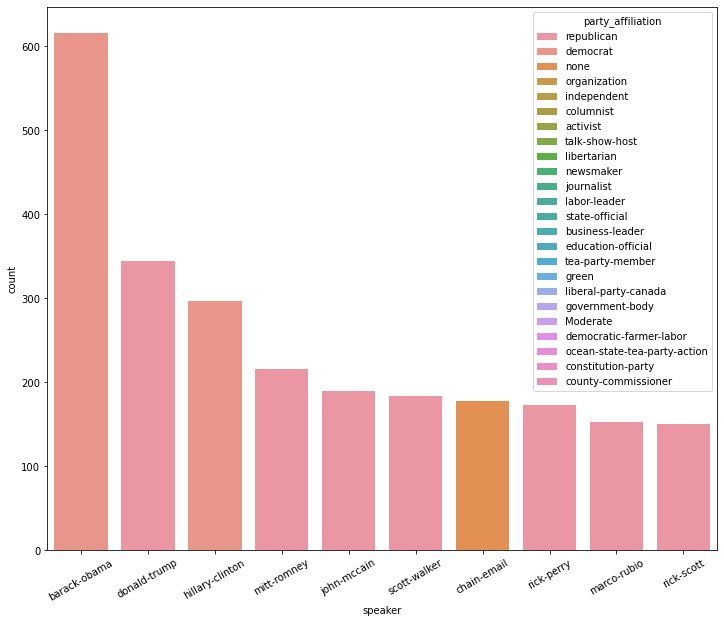

In [117]:
# plot news count by Top Speakers

plt.figure(figsize=(12,10))
ax = sns.countplot(x='speaker', data= df_full, hue='party_affiliation', 
                   order=df_full['speaker'].value_counts().iloc[:10].index, dodge=False)
plt.xticks(rotation = 30)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'barack-obama'),
  Text(1, 0, 'donald-trump'),
  Text(2, 0, 'hillary-clinton'),
  Text(3, 0, 'mitt-romney'),
  Text(4, 0, 'john-mccain'),
  Text(5, 0, 'scott-walker'),
  Text(6, 0, 'chain-email'),
  Text(7, 0, 'rick-perry'),
  Text(8, 0, 'marco-rubio'),
  Text(9, 0, 'rick-scott')])

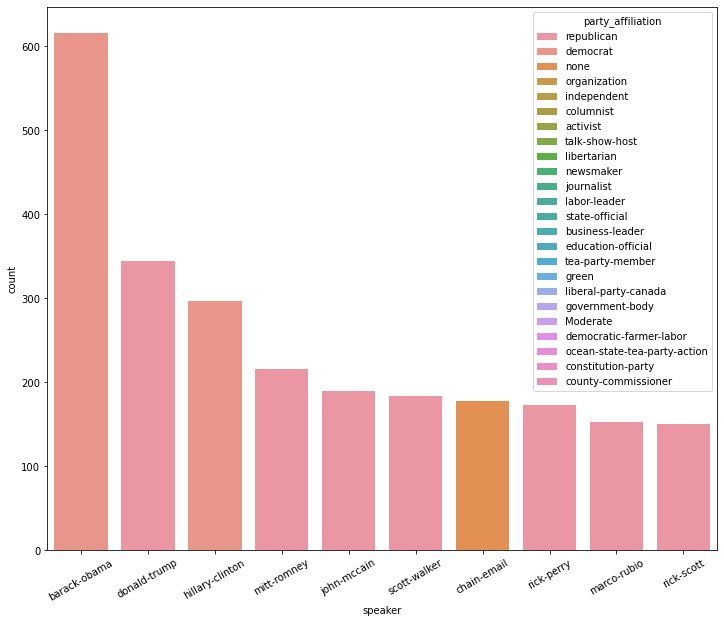

In [118]:
# plot news count by Top Speakers

plt.figure(figsize=(12,10))
ax = sns.countplot(x='speaker', data= df_full, hue='party_affiliation', 
                   order=df_full['speaker'].value_counts().iloc[:10].index, dodge=False)
plt.xticks(rotation = 30)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'barack-obama'),
  Text(1, 0, 'donald-trump'),
  Text(2, 0, 'hillary-clinton'),
  Text(3, 0, 'mitt-romney'),
  Text(4, 0, 'chain-email'),
  Text(5, 0, 'scott-walker'),
  Text(6, 0, 'john-mccain'),
  Text(7, 0, 'rick-perry'),
  Text(8, 0, 'rick-scott'),
  Text(9, 0, 'marco-rubio'),
  Text(10, 0, 'ted-cruz'),
  Text(11, 0, 'facebook-posts'),
  Text(12, 0, 'bernie-s'),
  Text(13, 0, 'chris-christie'),
  Text(14, 0, 'blog-posting'),
  Text(15, 0, 'newt-gingrich'),
  Text(16, 0, 'charlie-crist'),
  Text(17, 0, 'jeb-bush'),
  Text(18, 0, 'joe-biden'),
  Text(19, 0, 'paul-ryan')])

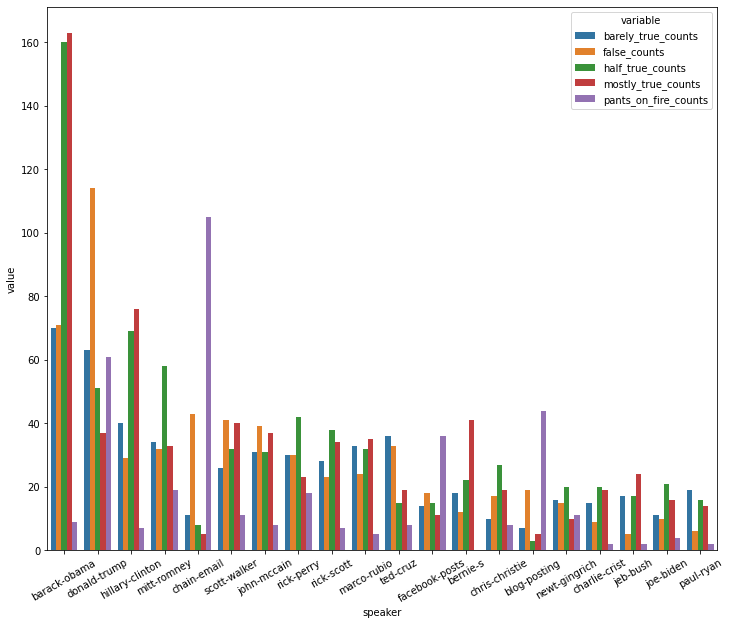

In [119]:
# Create melted DF of Category Counts
# Plot Top Speakers' Category Counts

df_speaker_TF = df_full.drop_duplicates(subset='speaker')
df_speaker_TF['news_count'] = df_speaker_TF[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']].sum(axis = 1)
df_most_speeches = df_speaker_TF.sort_values(by=['news_count'], ascending=False)[:20].drop(['news_count'], axis =1)
df_melt = pd.melt(df_most_speeches, id_vars=['speaker'], value_vars=['barely_true_counts','false_counts', 'half_true_counts',
                                                          'mostly_true_counts', 'pants_on_fire_counts'])


plt.figure(figsize=(12,10))
sns.barplot(x='speaker', y='value', data=df_melt, hue='variable')
plt.xticks(rotation = 30)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'democrat'),
  Text(1, 0, 'independent'),
  Text(2, 0, 'none'),
  Text(3, 0, 'organization'),
  Text(4, 0, 'republican')])

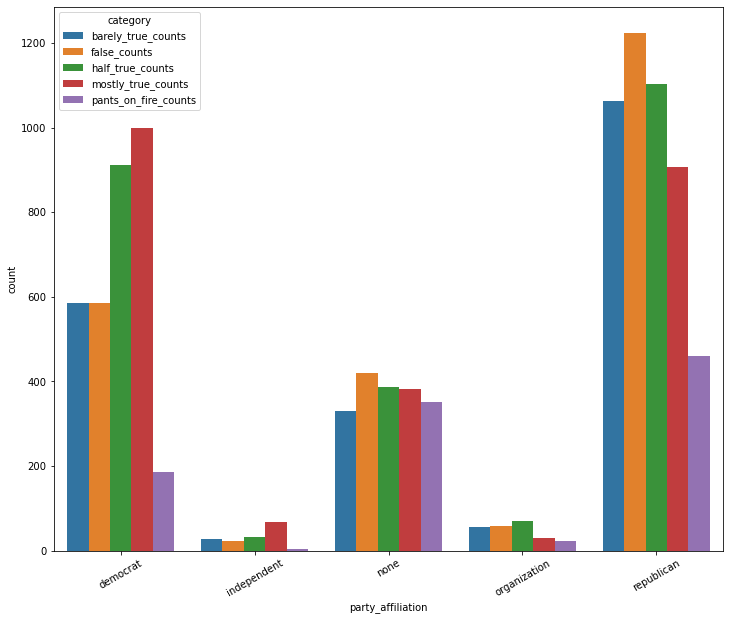

In [120]:
# Create melted DF on party affiliation
# Plot Category count by party affiliation

df_party = df_speaker_TF.groupby('party_affiliation').sum()[['barely_true_counts', 'false_counts','half_true_counts',
                                                             'mostly_true_counts', 'pants_on_fire_counts']].reset_index()
df_party_melt = pd.melt(df_party, id_vars=['party_affiliation'], value_vars=['barely_true_counts','false_counts', 'half_true_counts',
                                                          'mostly_true_counts', 'pants_on_fire_counts'])
df_party_melt = df_party_melt.rename(columns={'variable':'category', 'value':'count'})

df_top_party = df_party_melt[df_party_melt['party_affiliation'].isin(['republican','democrat','none', 'organization', 'independent'])]


plt.figure(figsize=(12,10))
sns.barplot(x='party_affiliation', y='count', data=df_top_party, hue='category')
plt.xticks(rotation = 30)

### Cleaning some Text for additional EDA

In [79]:
# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [80]:
# Applying the cleaning function to both test and training datasets
train['text_clean'] = train['statement'].apply(str).apply(lambda x: text_preprocessing(x))
test['text_clean'] = test['statement'].apply(str).apply(lambda x: text_preprocessing(x))
validation['text_clean'] = validation['statement'].apply(str).apply(lambda x: text_preprocessing(x))

In [81]:
train['text_len'] = train['text_clean'].astype(str).apply(len)
train['text_word_count'] = train['text_clean'].apply(lambda x: len(str(x).split()))

In [82]:

y_label_dict = {"pants-fire" : 0, "false" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "true" : 5}

pants_fire = train[train['label']==0]
false = train[train['label']==1]
barely_true = train[train['label']==2]
half_true = train[train['label']==3]
mostly_true = train[train['label']==4]
true = train[train['label']==5]

In [92]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from chart_studio.plotly import plot, iplot
import plotly.graph_objs as go

In [87]:
pants_fire['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Pants Fire Text Length Distribution')

false['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='False Text Length Distribution')

barely_true['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Barely True Text Length Distribution')

half_true['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='half_true Text Length Distribution')

mostly_true['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='mostly_true Text Length Distribution')

true['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='True Text Length Distribution')

In [122]:

trace0 = go.Box(
    y=pants_fire['text_len'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=false['text_len'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=barely_true['text_len'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)

trace3 = go.Box(
    y=mostly_true['text_len'],
    name = 'Neutral Text',
    marker = dict(
        color = 'purple',
    )
)
trace4 = go.Box(
    y=half_true['text_len'],
    name = 'Neutral Text',
    marker = dict(
        color = 'yellow',
    )
)
trace5 = go.Box(
    y=true['text_len'],
    name = 'Neutral Text',
    marker = dict(
        color = 'blue',
    )
)
data = [trace0, trace1, trace2,trace3,trace4,trace5]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

PlotlyRequestError: Authentication credentials were not provided.

In [ ]:
#how do we want to deal with Speaker?

X_train['speaker'].value_counts().head(30)

In [ ]:
#How do we want to deal w Job title
X_train['job_title'].value_counts().head(15)

In [ ]:
#How do we want to deal w state info?

X_train['state_info'].value_counts().head(30)

In [124]:
#How to deal w party_affiliatino
X_train['party_affiliation'].value_counts().head(30)

republican                      4510
democrat                        3345
none                            1746
organization                     220
independent                      149
newsmaker                         58
activist                          40
libertarian                       40
journalist                        38
columnist                         36
talk-show-host                    26
state-official                    20
labor-leader                      11
tea-party-member                  10
business-leader                    9
green                              3
education-official                 2
ocean-state-tea-party-action       1
democratic-farmer-labor            1
government-body                    1
Moderate                           1
constitution-party                 1
liberal-party-canada               1
Name: party_affiliation, dtype: int64

## Preprocessing data for Bert
BERT expects input data in a specific format

Tokenized dataset
All the vectors should be of the same size. Hence,we need to pad the text to achieve a common length. This length will be decided by the length of longest sentence, which we will have to calculate. Also, since we shall concatanate the text and the sentiment column, the length should be decided by the concatanated text column. We need to then differentiate between the Actual tokens and the Padded ones with the help of "Attention Masks".


From the Hugging face documentation: The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicate a value that should be attended to while 0 indicate a padded value.

Adding special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])

https://huggingface.co/docs/transformers/preprocessing

There is a very helpful function called encode_plus provided in the Tokenizer class which can prove to be real handly. It can seamlessly perform the following operations:

- Tokenize the text
- Add special tokens - [CLS] and [SEP]
- create token IDs
- Pad the sentences to a common length
- Create attention masks for the above PAD tokens


- input_ids are the indices corresponding to each token in the sentence.
- attention_mask indicates whether a token should be attended to or not.
- token_type_ids identifies which sequence a token belongs to when there is more than one sequence.

In [109]:
text = train['statement'].values

#Set the truncation parameter to True to truncate a sequence to the maximum length accepted by the model:
#Set the padding parameter to True to pad the shorter sequences in the batch to match the longest sequence
#Set the return_tensors parameter to either pt for PyTorch, or tf for TensorFlow:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
#print(encoded_input)


input_ids = []
attention_masks = []
token_type_ids = []

for i in range(len(text)):
    encoded = tokenizer.encode_plus(
      text[i],
        padding=True
        , truncation=True
        , return_tensors="tf")
    
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    token_type_ids.append(encoded['token_type_ids'])

#input_ids = torch.cat(input_ids, dim=0)
#attention_masks = torch.cat(attention_masks, dim=0)
#token_type_ids = torch.cat(token_type_ids, dim=0)


In [110]:
input_ids

[<tf.Tensor: shape=(1, 19), dtype=int32, numpy=
 array([[  101,  2758,  1996,  8194,  2015,  2862,  2576,  2177,  6753,
          2353,  1011, 12241, 20367, 11324,  2015,  2006,  5157,  1012,
           102]])>,
 <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
 array([[ 101, 2043, 2106, 1996, 6689, 1997, 5317, 2707, 1029, 2009, 2318,
         2043, 3019, 3806, 2165, 2125, 2008, 2318, 2000, 4088, 1999, 1006,
         2343, 2577, 1059, 1012, 1007, 5747, 2015, 3447, 1012,  102]])>,
 <tf.Tensor: shape=(1, 24), dtype=int32, numpy=
 array([[  101, 18520,  7207, 10217,  2007,  2198, 19186,  1000,  2011,
          6830,  2000,  2507,  2577,  5747,  1996,  5770,  1997,  1996,
          4797,  2006,  4238,  1012,  1000,   102]])>,
 <tf.Tensor: shape=(1, 16), dtype=int32, numpy=
 array([[  101,  2740,  2729,  5290,  6094,  2003,  3497,  2000, 11405,
          2489,  3348,  2689, 12058,  5134,  1012,   102]])>,
 <tf.Tensor: shape=(1, 14), dtype=int32, numpy=
 array([[  101,  1996,  3171,  2735, 244

## Creating Training/Test Data splits

In [27]:
y_train = train['label']
y_test = test['label']
y_validation = test['label']

In [28]:
X_train = train.drop('label', axis = 1)
X_test = test.drop('label', axis = 1)
X_validation = validation.drop('label', axis = 1)

In [29]:
X_train.head()

,id,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [75]:
# Applying the cleaning function to both test and training datasets
X_train['text_clean'] = X_train['statement'].apply(str).apply(lambda x: text_preprocessing(x))
X_test['text_clean'] = X_test['statement'].apply(str).apply(lambda x: text_preprocessing(x))
X_validation['text_clean'] = X_validation['statement'].apply(str).apply(lambda x: text_preprocessing(x))

In [78]:
X_train['text_len'] = X_train['text_clean'].astype(str).apply(len)
X_train['text_word_count'] = X_train['text_clean'].apply(lambda x: len(str(x).split()))

In [ ]:
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']
neutral = train[train['sentiment']=='neutral']

## TO DOS

- Perform EDA on the above
- Do some slight prepossesing (one hot encoding for some variables, etc.)
- begin modeling. I think we could try our hand at building our own model from scratch and then I think we can do some transfer learning for the other (BERT, or something that has been pre-trained. I know he said that pre-trained models are good for datasets that don't have a lot of samples)
- COULD ALSO TRY BINARY vs 6-WAY CLASSIFICATION

## For Modeling, we need to use multi input models I think
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [111]:
# define two sets of inputs
inputA = Input(shape=(32,))
inputB = Input(shape=(128,))
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

NameError: name 'Input' is not defined